# Proyecto Final - Módulo No Supervisado
**Maestría en Ciencias de Información y las Comunicaciones - Big Data**

---

**Autores**: Álvaro Alejandro Zarabanda Gutiérrez - Youssef Alejandro Ortiz  
**Códigos**: 20251595006 - 20251595004   
**Fecha**: Octubre 2025

## Importación de Librerías


In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy.io import loadmat, savemat
from itertools import product

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score, accuracy_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import NearestNeighbors
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
warnings.filterwarnings('ignore')

pyo.init_notebook_mode(connected=True)

np.random.seed(42)


## Parte 1: Carga y Análisis Exploratorio del Dataset


In [2]:

try:
    mat_data = loadmat('dato_taller.mat')
    
    print("\nClaves disponibles en el archivo .mat:")
    data_keys = []
    for key in mat_data.keys():
        if not key.startswith('__'):
            print(f"   {key}: {mat_data[key].shape} ({mat_data[key].dtype})")
            data_keys.append(key)
    
    print(f"\nSe encontraron {len(data_keys)} matrices de datos principales")
    
    for key in data_keys:
        data = mat_data[key]
        print(f"\nAnálisis de '{key}':")
        print(f"   Dimensiones: {data.shape}")
        print(f"   Tipo de datos: {data.dtype}")
        print(f"   Rango de valores: [{data.min():.4f}, {data.max():.4f}]")
        print(f"   Estadísticas: μ={data.mean():.4f}, σ={data.std():.4f}")
        
        # Si es un vector (posibles etiquetas)
        if len(data.shape) == 2 and min(data.shape) == 1:
            unique_vals = np.unique(data.flatten())
            print(f"   Valores únicos: {unique_vals}")
            print(f"   Distribución: {[(val, np.sum(data.flatten() == val)) for val in unique_vals]}")
    
except Exception as e:
    print(f"Error cargando el dataset: {e}")
    
print(f"\nDataset cargado exitosamente desde: {Path('dato_taller.mat').absolute()}")


Claves disponibles en el archivo .mat:
   x_prueba: (10000, 20) (float64)
   x_entena: (1000, 20) (float64)
   y_entrena: (1000, 1) (int16)

Se encontraron 3 matrices de datos principales

Análisis de 'x_prueba':
   Dimensiones: (10000, 20)
   Tipo de datos: float64
   Rango de valores: [-4.7194, 4.7795]
   Estadísticas: μ=0.0028, σ=1.0958

Análisis de 'x_entena':
   Dimensiones: (1000, 20)
   Tipo de datos: float64
   Rango de valores: [-4.0843, 4.4016]
   Estadísticas: μ=0.0117, σ=1.0977

Análisis de 'y_entrena':
   Dimensiones: (1000, 1)
   Tipo de datos: int16
   Rango de valores: [-1.0000, 1.0000]
   Estadísticas: μ=0.0620, σ=0.9981
   Valores únicos: [-1  1]
   Distribución: [(np.int16(-1), np.int64(469)), (np.int16(1), np.int64(531))]

Dataset cargado exitosamente desde: /home/aalejoz25/HDD/Alvaro/Universidad/Posgrado 1/Repositorios/Big_Data/aprendizaje_no_supervisado/trabajo_final/dato_taller.mat


In [3]:
# Extraer matrices de datos
X_train = mat_data['x_entena']  # Datos de entrenamiento
y_train = mat_data['y_entrena'].flatten()  # Etiquetas de entrenamiento 
X_test = mat_data['x_prueba']   # Datos de prueba

print(f"Información de los datos extraídos:")
print(f"X_train: {X_train.shape} - Datos de entrenamiento")
print(f"y_train: {y_train.shape} - Etiquetas de entrenamiento") 
print(f"X_test: {X_test.shape} - Datos de prueba")

unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f"\nDistribución de clases en entrenamiento:")
for clase, count in zip(unique_classes, class_counts):
    print(f"  Clase {clase}: {count} muestras ({count/len(y_train)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDatos normalizados exitosamente")
print(f"X_train_scaled: μ={X_train_scaled.mean():.6f}, σ={X_train_scaled.std():.6f}")
print(f"X_test_scaled: μ={X_test_scaled.mean():.6f}, σ={X_test_scaled.std():.6f}")

Información de los datos extraídos:
X_train: (1000, 20) - Datos de entrenamiento
y_train: (1000,) - Etiquetas de entrenamiento
X_test: (10000, 20) - Datos de prueba

Distribución de clases en entrenamiento:
  Clase -1: 469 muestras (46.9%)
  Clase 1: 531 muestras (53.1%)

Datos normalizados exitosamente
X_train_scaled: μ=-0.000000, σ=1.000000
X_test_scaled: μ=-0.008134, σ=1.000050


## Parte 2: Visualizaciones del Análisis Exploratorio de Datos (EDA)


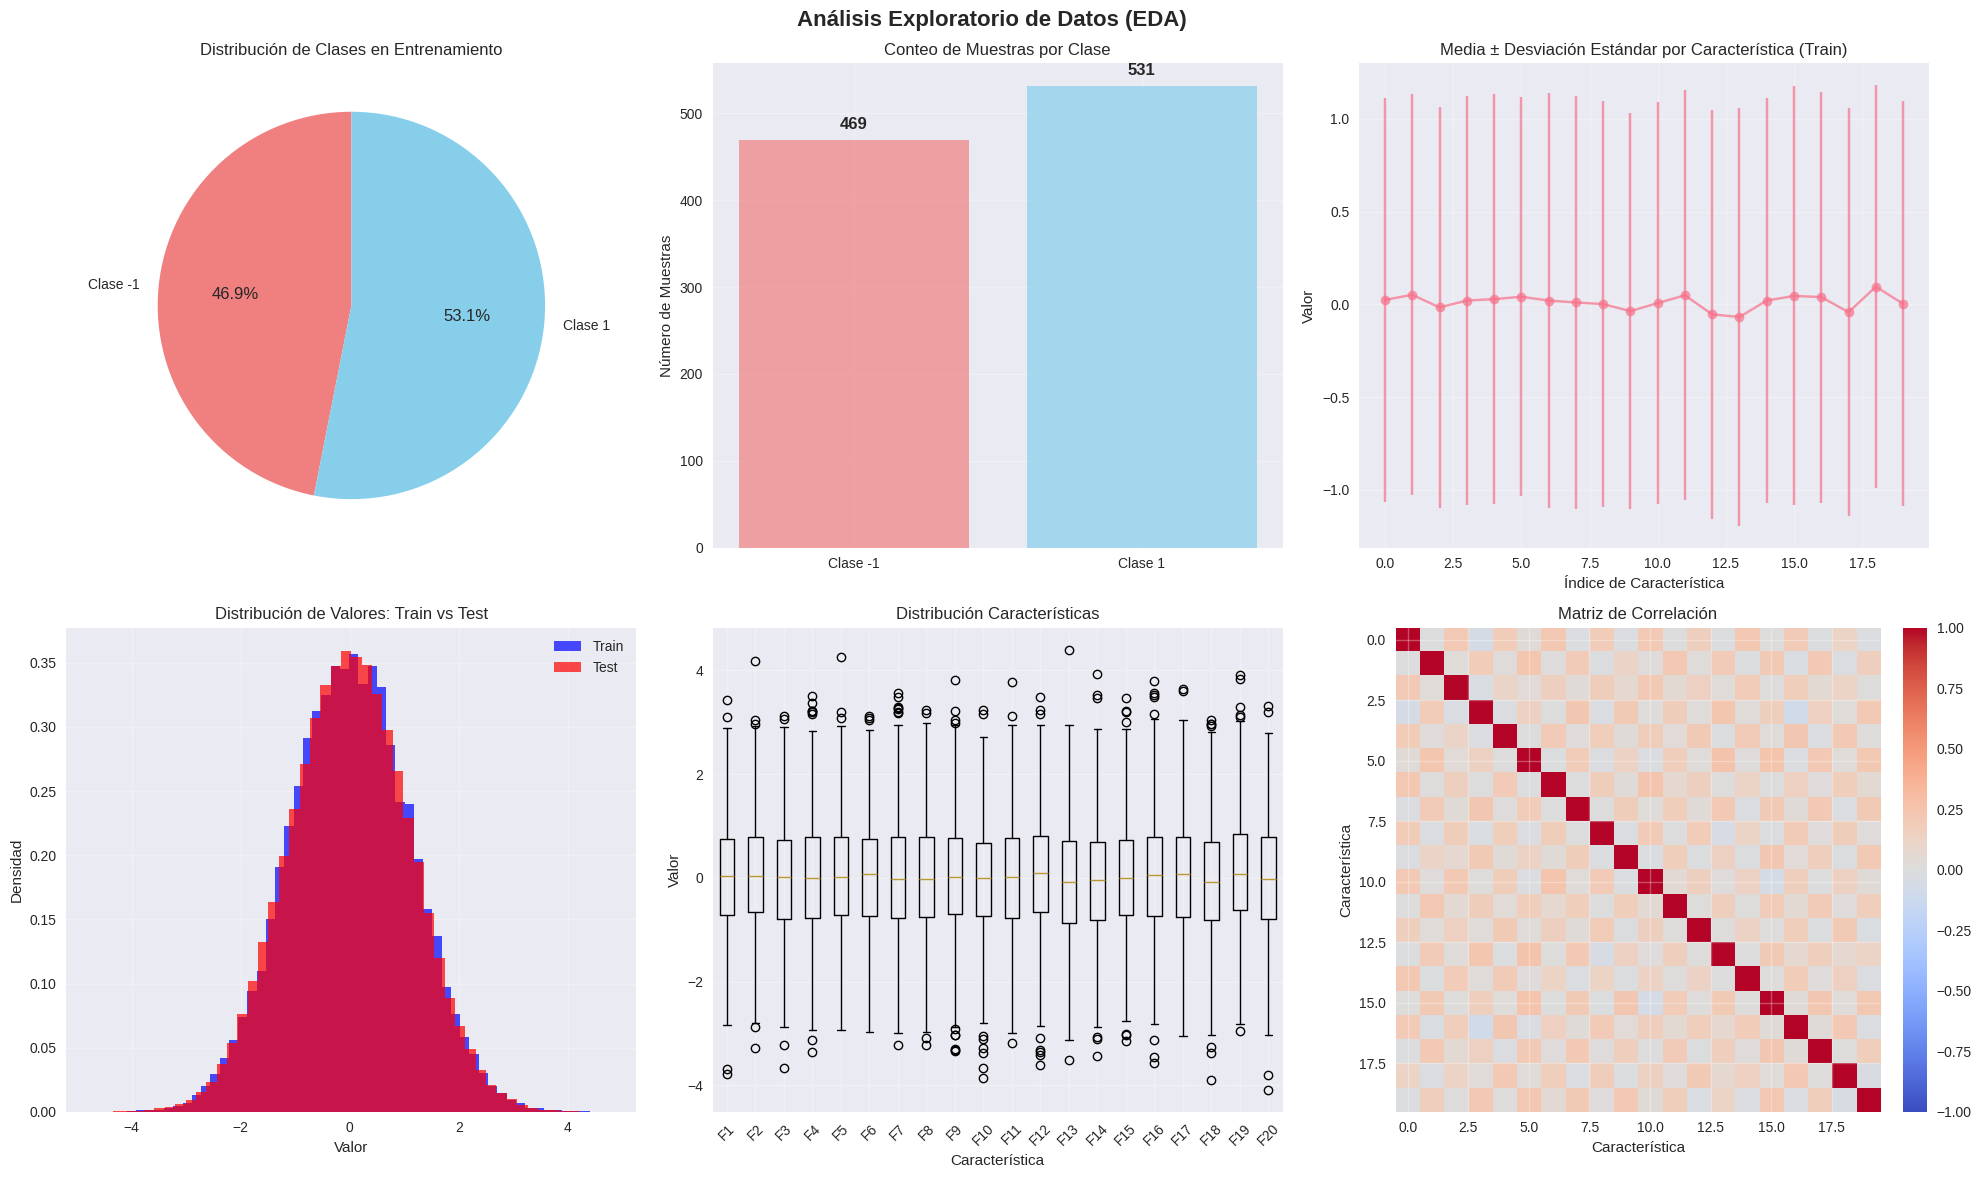


RESUMEN ESTADÍSTICO DEL DATASET
Conjunto de entrenamiento:
  - Tamaño: 1,000 muestras, 20 características
  - Rango de valores: [-4.0843, 4.4016]
  - Media global: 0.0117
  - Desviación estándar global: 1.0977

Conjunto de prueba:
  - Tamaño: 10,000 muestras, 20 características
  - Rango de valores: [-4.7194, 4.7795]
  - Media global: 0.0028
  - Desviación estándar global: 1.0958

Balance de clases:
  - Clase -1: 469 muestras (46.9%)
  - Clase 1: 531 muestras (53.1%)

Ratio de balance: 0.883 (Balanceado)


In [4]:

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis Exploratorio de Datos (EDA)', fontsize=16, fontweight='bold')

axes[0,0].pie(class_counts, labels=[f'Clase {c}' for c in unique_classes], 
              autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
axes[0,0].set_title('Distribución de Clases en Entrenamiento')

axes[0,1].bar([f'Clase {c}' for c in unique_classes], class_counts, 
              color=['lightcoral', 'skyblue'], alpha=0.7)
axes[0,1].set_title('Conteo de Muestras por Clase')
axes[0,1].set_ylabel('Número de Muestras')
for i, v in enumerate(class_counts):
    axes[0,1].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

feature_means_train = X_train.mean(axis=0)
feature_stds_train = X_train.std(axis=0)
feature_indices = np.arange(min(20, X_train.shape[1])) 

axes[0,2].errorbar(feature_indices, feature_means_train[:len(feature_indices)], 
                   yerr=feature_stds_train[:len(feature_indices)], 
                   fmt='o-', capsize=3, alpha=0.7)
axes[0,2].set_title('Media ± Desviación Estándar por Característica (Train)')
axes[0,2].set_xlabel('Índice de Característica')
axes[0,2].set_ylabel('Valor')
axes[0,2].grid(True, alpha=0.3)

axes[1,0].hist(X_train.flatten(), bins=50, alpha=0.7, label='Train', density=True, color='blue')
axes[1,0].hist(X_test.flatten(), bins=50, alpha=0.7, label='Test', density=True, color='red')
axes[1,0].set_title('Distribución de Valores: Train vs Test')
axes[1,0].set_xlabel('Valor')
axes[1,0].set_ylabel('Densidad')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

sample_features = X_train[:, :min(20, X_train.shape[1])]
axes[1,1].boxplot(sample_features, labels=[f'F{i+1}' for i in range(sample_features.shape[1])])
axes[1,1].set_title('Distribución Características')
axes[1,1].set_xlabel('Característica')
axes[1,1].set_ylabel('Valor')
axes[1,1].tick_params(axis='x', rotation=45)

n_features_corr = min(20, X_train.shape[1])
corr_matrix = np.corrcoef(X_train[:, :n_features_corr].T)
im = axes[1,2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1,2].set_title('Matriz de Correlación')
axes[1,2].set_xlabel('Característica')
axes[1,2].set_ylabel('Característica')
plt.colorbar(im, ax=axes[1,2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("\nRESUMEN ESTADÍSTICO DEL DATASET")
print("="*50)
print(f"Conjunto de entrenamiento:")
print(f"  - Tamaño: {X_train.shape[0]:,} muestras, {X_train.shape[1]} características")
print(f"  - Rango de valores: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"  - Media global: {X_train.mean():.4f}")
print(f"  - Desviación estándar global: {X_train.std():.4f}")

print(f"\nConjunto de prueba:")
print(f"  - Tamaño: {X_test.shape[0]:,} muestras, {X_test.shape[1]} características")
print(f"  - Rango de valores: [{X_test.min():.4f}, {X_test.max():.4f}]")
print(f"  - Media global: {X_test.mean():.4f}")
print(f"  - Desviación estándar global: {X_test.std():.4f}")

print(f"\nBalance de clases:")
for clase, count in zip(unique_classes, class_counts):
    print(f"  - Clase {clase}: {count:,} muestras ({count/len(y_train)*100:.1f}%)")

balance_ratio = min(class_counts) / max(class_counts)
print(f"\nRatio de balance: {balance_ratio:.3f} ({'Balanceado' if balance_ratio > 0.8 else 'Desbalanceado'})")

ANÁLISIS DE REDUCCIÓN DIMENSIONAL


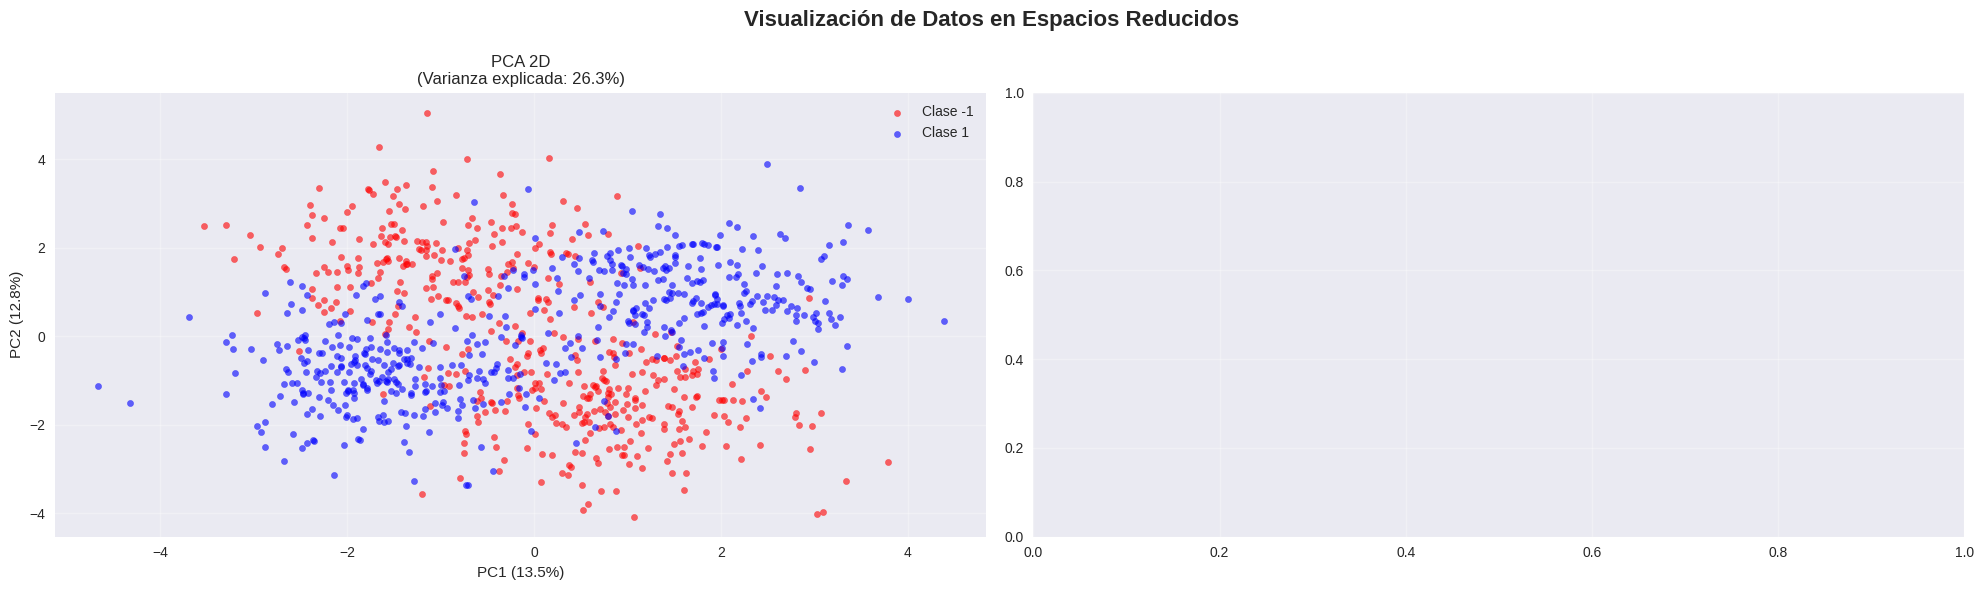


INFORMACIÓN DE PCA:
- Primeras 2 componentes explican: 26.3% de la varianza


In [5]:
print("ANÁLISIS DE REDUCCIÓN DIMENSIONAL")
print("="*50)

# Aplicar PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Crear visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Visualización de Datos en Espacios Reducidos', fontsize=16, fontweight='bold')

# Definir colores para las clases
colors = ['red', 'blue']
class_labels = [f'Clase {int(c)}' for c in unique_classes]

# 1. PCA 2D
for i, clase in enumerate(unique_classes):
    mask = y_train == clase
    axes[0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                   c=colors[i], label=class_labels[i], alpha=0.6, s=20)
axes[0].set_title(f'PCA 2D\n(Varianza explicada: {pca.explained_variance_ratio_.sum():.1%})')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Información adicional sobre PCA
print(f"\nINFORMACIÓN DE PCA:")
print(f"- Primeras 2 componentes explican: {pca.explained_variance_ratio_.sum():.1%} de la varianza")


## Parte 2.1: Configuración Extensiva de Modelos de Clustering


In [6]:


print("CONFIGURANDO EXPERIMENTOS DE CLUSTERING")
print("="*60)

clustering_configs = {
    'kmeans': {
        'n_clusters': [2, 3, 4, 5, 6, 7, 8],
        'n_init': [10],
        'random_state': [42]
    },
    'hierarchical': {
        'n_clusters': [2, 3, 4, 5, 6, 7, 8],
        'linkage': ['ward', 'complete', 'average', 'single']
    },
    'dbscan': {
        'eps': [0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0],
        'min_samples': [3, 4, 5, 6, 8, 10]
    }
}

all_models = []

# K-means
for n_clusters, n_init, random_state in product(
    clustering_configs['kmeans']['n_clusters'],
    clustering_configs['kmeans']['n_init'],
    clustering_configs['kmeans']['random_state']
):
    all_models.append({
        'algorithm': 'kmeans',
        'model': KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state),
        'params': {'n_clusters': n_clusters, 'n_init': n_init, 'random_state': random_state},
        'name': f'KMeans_K{n_clusters}'
    })

# Clustering Jerárquico
for n_clusters, linkage in product(
    clustering_configs['hierarchical']['n_clusters'],
    clustering_configs['hierarchical']['linkage']
):
    all_models.append({
        'algorithm': 'hierarchical',
        'model': AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage),
        'params': {'n_clusters': n_clusters, 'linkage': linkage},
        'name': f'Hierarchical_{linkage}_K{n_clusters}'
    })

# DBSCAN
for eps, min_samples in product(
    clustering_configs['dbscan']['eps'],
    clustering_configs['dbscan']['min_samples']
):
    all_models.append({
        'algorithm': 'dbscan',
        'model': DBSCAN(eps=eps, min_samples=min_samples),
        'params': {'eps': eps, 'min_samples': min_samples},
        'name': f'DBSCAN_eps{eps}_min{min_samples}'
    })

print(f"Total de modelos configurados: {len(all_models)}")
print(f"  - K-means: {len([m for m in all_models if m['algorithm'] == 'kmeans'])}")
print(f"  - Jerárquico: {len([m for m in all_models if m['algorithm'] == 'hierarchical'])}")
print(f"  - DBSCAN: {len([m for m in all_models if m['algorithm'] == 'dbscan'])}")

CONFIGURANDO EXPERIMENTOS DE CLUSTERING
Total de modelos configurados: 83
  - K-means: 7
  - Jerárquico: 28
  - DBSCAN: 48


## Parte 3: Entrenamiento y Evaluación No Supervisada

**Objetivo**: Entrenar todos los modelos y calcular métricas no supervisadas básicas.

In [7]:

results = []

for i, model_config in enumerate(all_models):
    print(f"\rProcesando modelo {i+1}/{len(all_models)}: {model_config['name']}", end='', flush=True)
    
    try:
        labels = model_config['model'].fit_predict(X_test_scaled)
        
        n_clusters = len(np.unique(labels))
        n_noise = np.sum(labels == -1) if -1 in labels else 0
        
        if n_clusters >= 2:
            if -1 in labels:
                mask = labels != -1
                if mask.sum() > 1 and len(np.unique(labels[mask])) >= 2:
                    X_filtered = X_test_scaled[mask]
                    labels_filtered = labels[mask]
                    silhouette = silhouette_score(X_filtered, labels_filtered)
                    calinski_harabasz = calinski_harabasz_score(X_filtered, labels_filtered)
                    davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)
                else:
                    silhouette = calinski_harabasz = davies_bouldin = np.nan
            else:
                silhouette = silhouette_score(X_test_scaled, labels)
                calinski_harabasz = calinski_harabasz_score(X_test_scaled, labels)
                davies_bouldin = davies_bouldin_score(X_test_scaled, labels)
        else:
            silhouette = calinski_harabasz = davies_bouldin = np.nan
        
        result = {
            'model_id': i,
            'name': model_config['name'],
            'algorithm': model_config['algorithm'],
            'params': model_config['params'],
            'model': model_config['model'],
            'labels': labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette,
            'calinski_harabasz': calinski_harabasz,
            'davies_bouldin': davies_bouldin,
            'valid': not np.isnan(silhouette)
        }
        
        results.append(result)
        
    except Exception as e:
        print(f"\nError en modelo {model_config['name']}: {e}")
        result = {
            'model_id': i,
            'name': model_config['name'],
            'algorithm': model_config['algorithm'],
            'params': model_config['params'],
            'model': model_config['model'],
            'labels': None,
            'n_clusters': 0,
            'n_noise': 0,
            'silhouette': np.nan,
            'calinski_harabasz': np.nan,
            'davies_bouldin': np.nan,
            'valid': False,
            'error': str(e)
        }
        results.append(result)

print(f"\n\nEntrenamiento completado!")
valid_results = [r for r in results if r['valid']]
print(f"Modelos válidos: {len(valid_results)}/{len(results)}")

# Resumen por algoritmo
for algo in ['kmeans', 'hierarchical', 'dbscan']:
    algo_results = [r for r in valid_results if r['algorithm'] == algo]
    print(f"  - {algo}: {len(algo_results)} modelos válidos")

Procesando modelo 1/83: KMeans_K2

Procesando modelo 83/83: DBSCAN_eps3.0_min10_K888

Entrenamiento completado!
Modelos válidos: 45/83
  - kmeans: 7 modelos válidos
  - hierarchical: 28 modelos válidos
  - dbscan: 10 modelos válidos


Entrenamiento completado!
Modelos válidos: 45/83
  - kmeans: 7 modelos válidos
  - hierarchical: 28 modelos válidos
  - dbscan: 10 modelos válidos


## Parte 4: Evaluación Semi-supervisada de TODOS los Modelos

**Objetivo**: Aplicar evaluación semi-supervisada a todos los modelos válidos.

In [8]:
def label_clusters_majority_vote(cluster_labels, true_labels):
    """
    Etiqueta cada cluster según la clase mayoritaria
    """
    from collections import Counter
    
    cluster_mapping = {}
    cluster_purity = {}
    predicted_labels = np.copy(cluster_labels)
    
    unique_clusters = np.unique(cluster_labels)
    if -1 in unique_clusters:
        unique_clusters = unique_clusters[unique_clusters != -1]
    
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        cluster_true_labels = true_labels[cluster_mask]
        
        if len(cluster_true_labels) > 0:
            label_counts = Counter(cluster_true_labels)
            majority_label = label_counts.most_common(1)[0][0]
            majority_count = label_counts.most_common(1)[0][1]
            
            purity = majority_count / len(cluster_true_labels)
            
            # Guardar mapeo y pureza
            cluster_mapping[cluster_id] = majority_label
            cluster_purity[cluster_id] = purity
            
            predicted_labels[cluster_mask] = majority_label
    
    if -1 in cluster_labels:
        noise_mask = cluster_labels == -1
        most_common_label = Counter(true_labels).most_common(1)[0][0]
        predicted_labels[noise_mask] = most_common_label
        cluster_mapping[-1] = most_common_label
        cluster_purity[-1] = 0.0
    
    return predicted_labels, cluster_mapping, cluster_purity

In [9]:

for i, result in enumerate(valid_results):
    print(f"\rProcesando evaluación semi-supervisada {i+1}/{len(valid_results)}: {result['name']}", 
          end='', flush=True)
    
    try:
        if result['algorithm'] == 'kmeans':
            train_labels = result['model'].predict(X_train_scaled)
        elif result['algorithm'] == 'hierarchical':
            from sklearn.cluster import AgglomerativeClustering
            temp_model = AgglomerativeClustering(**result['params'])
            train_labels = temp_model.fit_predict(X_train_scaled)
        elif result['algorithm'] == 'dbscan':
            from sklearn.neighbors import NearestNeighbors
            core_samples = result['model'].core_sample_indices_
            if len(core_samples) > 0:
                nbrs = NearestNeighbors(n_neighbors=1).fit(X_test_scaled[core_samples])
                distances, indices = nbrs.kneighbors(X_train_scaled)
                train_labels = result['labels'][core_samples[indices.flatten()]]
            else:
                # Si no hay core samples, asignar todo como ruido
                train_labels = np.full(len(X_train_scaled), -1)
        
        # PASO 2: Etiquetado por voto mayoritario usando las etiquetas de entrenamiento
        predicted_labels, cluster_mapping, cluster_purity = label_clusters_majority_vote(
            train_labels, y_train
        )
        
        accuracy = accuracy_score(y_train, predicted_labels)
        ari = adjusted_rand_score(y_train, train_labels)
        nmi = normalized_mutual_info_score(y_train, train_labels)
        
        total_samples = len(y_train)
        weighted_purity = 0
        for cluster_id, purity in cluster_purity.items():
            if cluster_id != -1:
                cluster_size = np.sum(train_labels == cluster_id)
                if cluster_size > 0:
                    weighted_purity += purity * (cluster_size / total_samples)
        
        from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
        
        # Matriz de confusión
        cm = confusion_matrix(y_train, predicted_labels)
        
        # Métricas clásicas de clasificación
        precision = precision_score(y_train, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(y_train, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(y_train, predicted_labels, average='weighted', zero_division=0)
        
        # Especificidad y sensibilidad por clase (para caso binario)
        if len(np.unique(y_train)) == 2:
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall de clase positiva
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Especificidad
        else:
            sensitivity = recall  # Para múltiples clases usar recall promedio
            specificity = recall
        
        # Actualizar resultado
        result.update({
            'train_labels': train_labels,
            'predicted_labels': predicted_labels,
            'cluster_mapping': cluster_mapping,
            'cluster_purity': cluster_purity,
            'confusion_matrix': cm,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ari': ari,
            'nmi': nmi,
            'weighted_purity': weighted_purity
        })
        
    except Exception as e:
        print(f"\nError en evaluación semi-supervisada de {result['name']}: {e}")
        result.update({
            'confusion_matrix': np.array([[0, 0], [0, 0]]),
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1_score': np.nan,
            'sensitivity': np.nan,
            'specificity': np.nan,
            'ari': np.nan,
            'nmi': np.nan,
            'weighted_purity': np.nan,
            'semi_supervised_error': str(e)
        })

print(f"\n\nEvaluación semi-supervisada completada para {len(valid_results)} modelos")

complete_results = [model for model in valid_results 
                   if 'f1_score' in model and not np.isnan(model['f1_score'])]

print(f"Modelos con evaluación completa: {len(complete_results)}")

if len(complete_results) > 0:
    print(f"\nTop 3 modelos por F1-Score:")
    sorted_models = sorted(complete_results, key=lambda x: x['f1_score'], reverse=True)
    for i, model in enumerate(sorted_models[:3]):
        print(f"  {i+1}. {model['name']} ({model['algorithm']}): F1={model['f1_score']:.4f}")
        print(f"     - Accuracy: {model['accuracy']:.4f}, Precision: {model['precision']:.4f}")
        print(f"     - Recall: {model['recall']:.4f}, Silhouette: {model['silhouette']:.4f}")

Procesando evaluación semi-supervisada 45/45: DBSCAN_eps3.0_min10_K888

Evaluación semi-supervisada completada para 45 modelos
Modelos con evaluación completa: 45

Top 3 modelos por F1-Score:
  1. KMeans_K4 (kmeans): F1=0.8510
     - Accuracy: 0.8510, Precision: 0.8510
     - Recall: 0.8510, Silhouette: 0.0667
  2. KMeans_K5 (kmeans): F1=0.8501
     - Accuracy: 0.8500, Precision: 0.8554
     - Recall: 0.8500, Silhouette: 0.0556
  3. KMeans_K8 (kmeans): F1=0.8411
     - Accuracy: 0.8410, Precision: 0.8412
     - Recall: 0.8410, Silhouette: 0.0347


Evaluación semi-supervisada completada para 45 modelos
Modelos con evaluación completa: 45

Top 3 modelos por F1-Score:
  1. KMeans_K4 (kmeans): F1=0.8510
     - Accuracy: 0.8510, Precision: 0.8510
     - Recall: 0.8510, Silhouette: 0.0667
  2. KMeans_K5 (kmeans): F1=0.8501
     - Accuracy: 0.8500, Precision: 0.8554
     - Recall: 0.8500, Silhouette: 0.0556
  3. KMeans_K8 (kmeans): F1=0.8411
     - Accuracy: 0.8410, Precision: 0.8412
     - R

## Parte 5: Selección del Mejor Modelo por Tipo

In [10]:

print("SELECCIONANDO EL MEJOR MODELO DE CADA TIPO")
print("="*60)

# Filtrar resultados válidos con métricas semi-supervisadas
complete_results = [r for r in valid_results if not np.isnan(r.get('accuracy', np.nan))]
print(f"Modelos con evaluación completa: {len(complete_results)}")

# Seleccionar mejor modelo por tipo usando F1-Score
best_models_by_type = {}

for algorithm in ['kmeans', 'hierarchical', 'dbscan']:
    algorithm_results = [r for r in complete_results if r['algorithm'] == algorithm]
    
    if algorithm_results:
        # Ordenar por F1-Score (métrica clásica más interpretable)
        algorithm_results.sort(key=lambda x: x['f1_score'], reverse=True)
        best_model = algorithm_results[0]
        best_models_by_type[algorithm] = best_model
        
        print(f"\nMejor modelo {algorithm.upper()}:")
        print(f"  Nombre: {best_model['name']}")
        print(f"  Parámetros: {best_model['params']}")
        print(f"  Accuracy: {best_model['accuracy']:.4f}")
        print(f"  Silhouette: {best_model['silhouette']:.4f}")
        print(f"  ARI: {best_model['ari']:.4f}")
        print(f"  NMI: {best_model['nmi']:.4f}")
        print(f"  F1-Score: {best_model['f1_score']:.4f}")
        print(f"  Clusters: {best_model['n_clusters']}, Ruido: {best_model['n_noise']}")
        
        # Top 5 modelos del tipo
        print(f"\n  Top 5 modelos {algorithm}:")
        for j, model in enumerate(algorithm_results[:5]):
            print(f"    {j+1}. {model['name']}: F1={model['f1_score']:.4f}, "
                  f"Acc={model['accuracy']:.4f}, Sil={model['silhouette']:.4f}")
    else:
        print(f"\nNo hay modelos válidos para {algorithm}")

print(f"\nSelección completada. Mejores modelos por tipo: {len(best_models_by_type)}")

SELECCIONANDO EL MEJOR MODELO DE CADA TIPO
Modelos con evaluación completa: 45

Mejor modelo KMEANS:
  Nombre: KMeans_K4
  Parámetros: {'n_clusters': 4, 'n_init': 10, 'random_state': 42}
  Accuracy: 0.8510
  Silhouette: 0.0667
  ARI: 0.2452
  NMI: 0.2613
  F1-Score: 0.8510
  Clusters: 4, Ruido: 0

  Top 5 modelos kmeans:
    1. KMeans_K4: F1=0.8510, Acc=0.8510, Sil=0.0667
    2. KMeans_K5: F1=0.8501, Acc=0.8500, Sil=0.0556
    3. KMeans_K8: F1=0.8411, Acc=0.8410, Sil=0.0347
    4. KMeans_K7: F1=0.8350, Acc=0.8350, Sil=0.0394
    5. KMeans_K6: F1=0.8214, Acc=0.8230, Sil=0.0452

Mejor modelo HIERARCHICAL:
  Nombre: Hierarchical_ward_K4
  Parámetros: {'n_clusters': 4, 'linkage': 'ward'}
  Accuracy: 0.7590
  Silhouette: 0.0429
  ARI: 0.1352
  NMI: 0.1625
  F1-Score: 0.7528
  Clusters: 4, Ruido: 0

  Top 5 modelos hierarchical:
    1. Hierarchical_ward_K4: F1=0.7528, Acc=0.7590, Sil=0.0429
    2. Hierarchical_ward_K5: F1=0.7528, Acc=0.7590, Sil=0.0276
    3. Hierarchical_ward_K6: F1=0.7528,

## Parte 6: Comparación Final y Selección del Modelo Óptimo


In [11]:

print("COMPARACIÓN FINAL DE LOS MEJORES MODELOS POR TIPO")
print("="*70)

# Crear tabla comparativa
comparison_data = []

for algorithm, best_model in best_models_by_type.items():
    comparison_data.append({
        'Algoritmo': algorithm.upper(),
        'Configuración': best_model['name'],
        'Parámetros': str(best_model['params']),
        'Accuracy': f"{best_model['accuracy']:.4f}",
        'Precision': f"{best_model['precision']:.4f}",
        'Recall': f"{best_model['recall']:.4f}",
        'F1_Score': f"{best_model['f1_score']:.4f}",
        'Sensitivity': f"{best_model['sensitivity']:.4f}",
        'Specificity': f"{best_model['specificity']:.4f}",
        'Silhouette': f"{best_model['silhouette']:.4f}",
        'N_Clusters': best_model['n_clusters'],
        'N_Ruido': best_model['n_noise']
    })

# Mostrar tabla comparativa
df_comparison = pd.DataFrame(comparison_data)
print("\nTabla Comparativa de Mejores Modelos:")
print(df_comparison.to_string(index=False))

# Seleccionar modelo final basado en F1-Score
final_best_model = max(best_models_by_type.values(), key=lambda x: x['f1_score'])

print(f"\nMODELO FINAL SELECCIONADO:")
print(f"="*40)
print(f"Algoritmo: {final_best_model['algorithm'].upper()}")
print(f"Configuración: {final_best_model['name']}")
print(f"Parámetros: {final_best_model['params']}")
print(f"F1-Score: {final_best_model['f1_score']:.4f}")
print(f"")
print(f"MÉTRICAS CLÁSICAS DE CLASIFICACIÓN:")
print(f"  - Accuracy: {final_best_model['accuracy']:.4f}")
print(f"  - Precision: {final_best_model['precision']:.4f}")
print(f"  - Recall (Sensitivity): {final_best_model['recall']:.4f}")
print(f"  - Specificity: {final_best_model['specificity']:.4f}")
print(f"  - F1-Score: {final_best_model['f1_score']:.4f}")
print(f"")
print(f"MÉTRICAS DE CLUSTERING:")
print(f"  - Silhouette Score: {final_best_model['silhouette']:.4f}")
print(f"  - Adjusted Rand Index: {final_best_model['ari']:.4f}")
print(f"  - Normalized Mutual Info: {final_best_model['nmi']:.4f}")
print(f"")
print(f"ESTRUCTURA DE CLUSTERS:")
print(f"  - Número de clusters: {final_best_model['n_clusters']}")
print(f"  - Puntos de ruido: {final_best_model['n_noise']}")

# Mostrar matriz de confusión del modelo final
print(f"\nMATRIZ DE CONFUSIÓN:")
cm = final_best_model['confusion_matrix']
print(f"                  Predicho")
print(f"                -1    +1")
print(f"Real      -1   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"          +1   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Interpretar matriz de confusión
tn, fp, fn, tp = cm.ravel()
print(f"\nINTERPRETACIÓN DE LA MATRIZ:")
print(f"  - Verdaderos Negativos (TN): {tn}")
print(f"  - Falsos Positivos (FP): {fp}")
print(f"  - Falsos Negativos (FN): {fn}")
print(f"  - Verdaderos Positivos (TP): {tp}")
print(f"  - Tasa de Error: {(fp + fn) / (tn + fp + fn + tp):.4f}")
print(f"  - Tasa de Acierto: {(tn + tp) / (tn + fp + fn + tp):.4f}")

# Mapeo de clusters del modelo final
print(f"\nMapeo de Clusters del Modelo Final:")
for cluster_id, label in final_best_model['cluster_mapping'].items():
    purity = final_best_model['cluster_purity'][cluster_id]
    cluster_size = np.sum(final_best_model['labels'] == cluster_id)
    if cluster_id == -1:
        print(f"  Ruido -> Clase {label} | {cluster_size} muestras (pureza: {purity:.3f})")
    else:
        print(f"  Cluster {cluster_id} -> Clase {label} | {cluster_size} muestras (pureza: {purity:.3f})")

COMPARACIÓN FINAL DE LOS MEJORES MODELOS POR TIPO

Tabla Comparativa de Mejores Modelos:


   Algoritmo        Configuración                                          Parámetros Accuracy Precision Recall F1_Score Sensitivity Specificity Silhouette  N_Clusters  N_Ruido
      KMEANS            KMeans_K4 {'n_clusters': 4, 'n_init': 10, 'random_state': 42}   0.8510    0.8510 0.8510   0.8510      0.8606      0.8401     0.0667           4        0
HIERARCHICAL Hierarchical_ward_K4                {'n_clusters': 4, 'linkage': 'ward'}   0.7590    0.7739 0.7590   0.7528      0.8945      0.6055     0.0429           4        0
      DBSCAN   DBSCAN_eps2.5_min3                      {'eps': 2.5, 'min_samples': 3}   0.7290    0.7292 0.7290   0.7278      0.7834      0.6674     0.0821          60     9680

MODELO FINAL SELECCIONADO:
Algoritmo: KMEANS
Configuración: KMeans_K4
Parámetros: {'n_clusters': 4, 'n_init': 10, 'random_state': 42}
F1-Score: 0.8510

MÉTRICAS CLÁSICAS DE CLASIFICACIÓN:
  - Accuracy: 0.8510
  - Precision: 0.8510
  - Recall (Sensitivity): 0.8510
  - Specificity: 0.8401
  -

## Parte 6.1: Visualizaciones de Análisis de Modelos


GENERANDO VISUALIZACIONES DE ANÁLISIS DE MODELOS


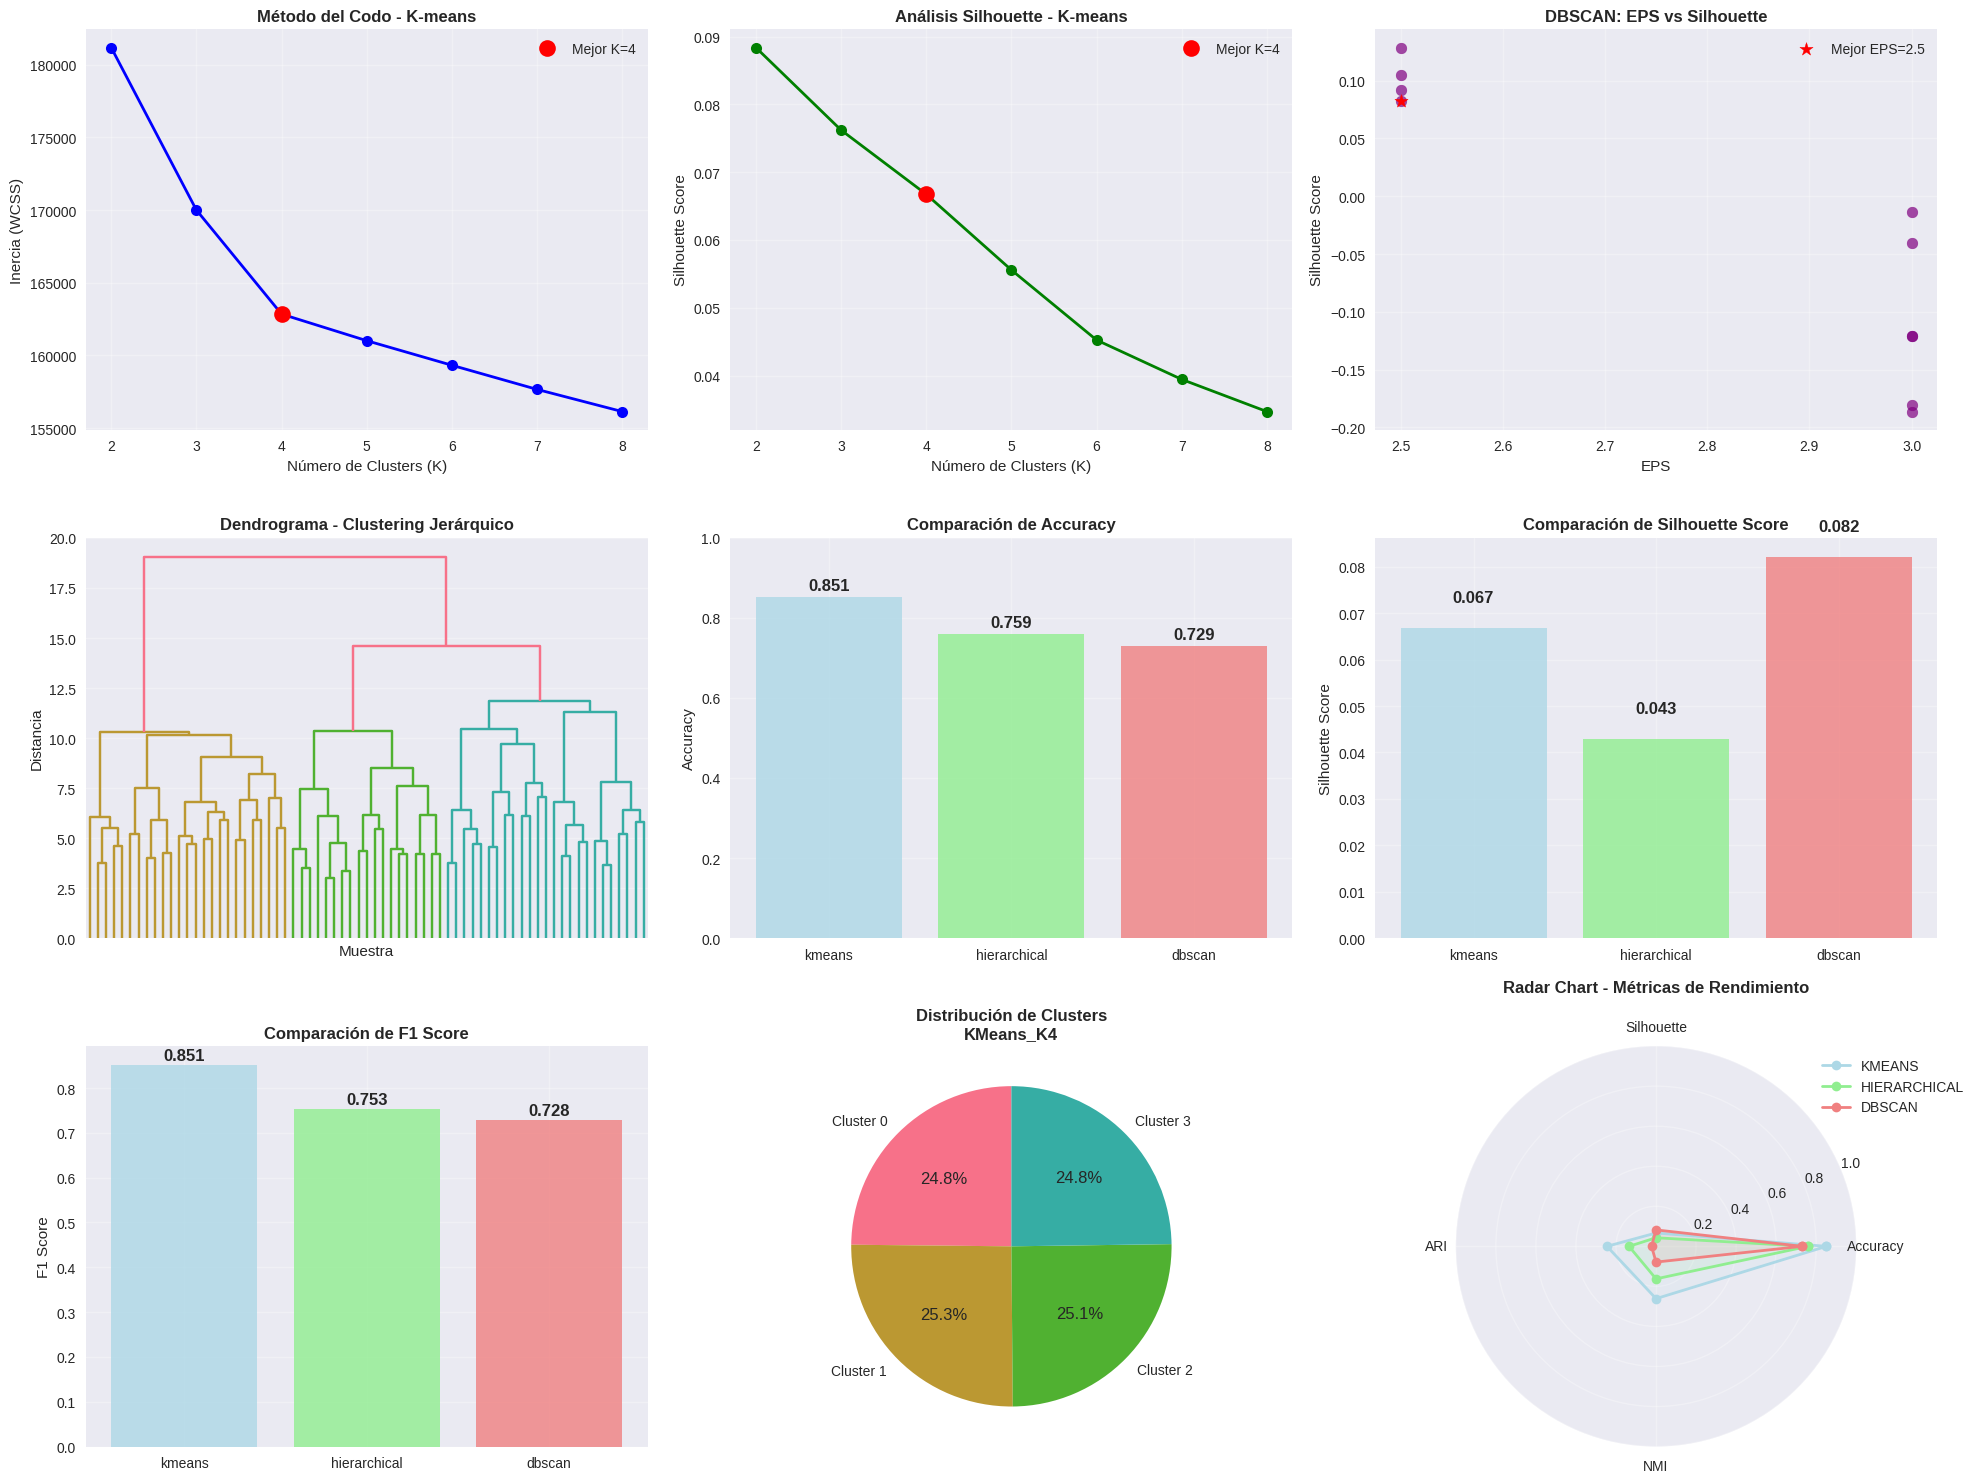

In [12]:


print("GENERANDO VISUALIZACIONES DE ANÁLISIS DE MODELOS")
print("="*60)

# Preparar datos para visualizaciones
kmeans_results = [m for m in complete_results if m['algorithm'] == 'kmeans']
dbscan_results = [m for m in complete_results if m['algorithm'] == 'dbscan']
hierarchical_results = [m for m in complete_results if m['algorithm'] == 'hierarchical']

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(20, 15))

# 1. MÉTODO DEL CODO PARA K-MEANS
ax1 = plt.subplot(3, 3, 1)
if kmeans_results:
    k_values = [m['n_clusters'] for m in kmeans_results]
    silhouettes = [m['silhouette'] for m in kmeans_results]
    inertias = []
    
    # Calcular inercias para el método del codo
    for k in sorted(set(k_values)):
        kmeans_temp = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans_temp.fit(X_test_scaled)
        inertias.append(kmeans_temp.inertia_)
    
    k_sorted = sorted(set(k_values))
    plt.plot(k_sorted, inertias, 'bo-', linewidth=2, markersize=8)
    plt.title('Método del Codo - K-means', fontweight='bold')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inercia (WCSS)')
    plt.grid(True, alpha=0.3)
    
    # Marcar el mejor K
    best_kmeans = max(kmeans_results, key=lambda x: x['f1_score'])
    best_k = best_kmeans['n_clusters']
    best_inertia_idx = k_sorted.index(best_k)
    plt.plot(best_k, inertias[best_inertia_idx], 'ro', markersize=12, label=f'Mejor K={best_k}')
    plt.legend()

# 2. SILHOUETTE SCORE PARA K-MEANS
ax2 = plt.subplot(3, 3, 2)
if kmeans_results:
    plt.plot(k_values, silhouettes, 'go-', linewidth=2, markersize=8)
    plt.title('Análisis Silhouette - K-means', fontweight='bold')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True, alpha=0.3)
    
    # Marcar el mejor
    best_sil = best_kmeans['silhouette']
    plt.plot(best_k, best_sil, 'ro', markersize=12, label=f'Mejor K={best_k}')
    plt.legend()

# 3. ANÁLISIS DBSCAN - EPS vs SILHOUETTE
ax3 = plt.subplot(3, 3, 3)
if dbscan_results:
    eps_values = [m['params']['eps'] for m in dbscan_results]
    dbscan_silhouettes = [m['silhouette'] for m in dbscan_results]
    
    plt.scatter(eps_values, dbscan_silhouettes, c='purple', s=60, alpha=0.7)
    plt.title('DBSCAN: EPS vs Silhouette', fontweight='bold')
    plt.xlabel('EPS')
    plt.ylabel('Silhouette Score')
    plt.grid(True, alpha=0.3)
    
    # Marcar el mejor
    best_dbscan = max(dbscan_results, key=lambda x: x['f1_score'])
    best_eps = best_dbscan['params']['eps']
    best_dbscan_sil = best_dbscan['silhouette']
    plt.scatter(best_eps, best_dbscan_sil, c='red', s=100, marker='*', 
               label=f'Mejor EPS={best_eps}')
    plt.legend()

# 4. DENDROGRAMA PARA CLUSTERING JERÁRQUICO
ax4 = plt.subplot(3, 3, 4)
if hierarchical_results:
    # Usar una muestra pequeña para el dendrograma
    sample_size = min(100, len(X_train_scaled))
    sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    X_sample = X_train_scaled[sample_indices]
    
    # Calcular linkage matrix usando scipy
    from scipy.cluster.hierarchy import linkage as scipy_linkage
    linkage_matrix = scipy_linkage(X_sample, method='ward')
    
    # Crear dendrograma
    dendrogram(linkage_matrix, truncate_mode='level', p=6, no_labels=True)
    plt.title('Dendrograma - Clustering Jerárquico', fontweight='bold')
    plt.xlabel('Muestra')
    plt.ylabel('Distancia')

# 5. COMPARACIÓN DE MÉTRICAS - ACCURACY
ax5 = plt.subplot(3, 3, 5)
algorithms = list(best_models_by_type.keys())
accuracies = [best_models_by_type[alg]['accuracy'] for alg in algorithms]
colors_bar = ['lightblue', 'lightgreen', 'lightcoral']

bars = plt.bar(algorithms, accuracies, color=colors_bar, alpha=0.8)
plt.title('Comparación de Accuracy', fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Añadir valores sobre las barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. COMPARACIÓN DE MÉTRICAS - SILHOUETTE
ax6 = plt.subplot(3, 3, 6)
silhouettes_comp = [best_models_by_type[alg]['silhouette'] for alg in algorithms]

bars = plt.bar(algorithms, silhouettes_comp, color=colors_bar, alpha=0.8)
plt.title('Comparación de Silhouette Score', fontweight='bold')
plt.ylabel('Silhouette Score')

for bar, sil in zip(bars, silhouettes_comp):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005, 
             f'{sil:.3f}', ha='center', va='bottom', fontweight='bold')

# 7. COMPOSITE SCORE COMPARISON
ax7 = plt.subplot(3, 3, 7)
composite_scores = [best_models_by_type[alg]['f1_score'] for alg in algorithms]

bars = plt.bar(algorithms, composite_scores, color=colors_bar, alpha=0.8)
plt.title('Comparación de F1 Score', fontweight='bold')
plt.ylabel('F1 Score')

for bar, score in zip(bars, composite_scores):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 8. DISTRIBUCIÓN DE CLUSTERS - MEJOR MODELO
ax8 = plt.subplot(3, 3, 8)
best_model_overall = max(best_models_by_type.values(), key=lambda x: x['f1_score'])
cluster_labels = best_model_overall['labels']
unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)

# Filtrar ruido si existe
non_noise_mask = unique_clusters != -1
if np.any(~non_noise_mask):
    noise_count = cluster_counts[~non_noise_mask][0]
    unique_clusters = unique_clusters[non_noise_mask]
    cluster_counts = cluster_counts[non_noise_mask]
    
    plt.pie(np.append(cluster_counts, noise_count), 
            labels=[f'Cluster {c}' for c in unique_clusters] + ['Ruido'],
            autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribución de Clusters\n{best_model_overall["name"]}', fontweight='bold')
else:
    plt.pie(cluster_counts, labels=[f'Cluster {c}' for c in unique_clusters],
            autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribución de Clusters\n{best_model_overall["name"]}', fontweight='bold')

# 9. RADAR CHART DE MÉTRICAS
ax9 = plt.subplot(3, 3, 9, projection='polar')

# Preparar datos para radar chart
metrics = ['Accuracy', 'Silhouette', 'ARI', 'NMI']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

for i, (alg, model) in enumerate(best_models_by_type.items()):
    values = [model['accuracy'], model['silhouette'], model['ari'], model['nmi']]
    values += values[:1]  # Cerrar el círculo
    
    ax9.plot(angles, values, 'o-', linewidth=2, label=alg.upper(), color=colors_bar[i])
    ax9.fill(angles, values, alpha=0.1, color=colors_bar[i])

ax9.set_xticks(angles[:-1])
ax9.set_xticklabels(metrics)
ax9.set_ylim(0, 1)
ax9.set_title('Radar Chart - Métricas de Rendimiento', fontweight='bold', pad=20)
ax9.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()


## Parte 7: Aplicación a Datos de Prueba y Generación de Predicciones

**Objetivo**: Aplicar el modelo final a los datos de prueba y generar archivo .mat con predicciones.

In [13]:



def apply_final_model_to_test(best_model, X_train, X_test, y_train):
    """
    Aplica el modelo final a datos de prueba
    """
    algorithm = best_model['algorithm']
    params = best_model['params']
    
    print(f"Aplicando {algorithm.upper()} con parámetros: {params}")
    
    if algorithm == 'kmeans':
        # Para K-means, podemos usar predict directamente
        model = KMeans(**params)
        train_clusters = model.fit_predict(X_train)
        test_clusters = model.predict(X_test)
        
    elif algorithm == 'hierarchical':
        # Para jerárquico, entrenar con datos de entrenamiento y asignar por distancia
        model = AgglomerativeClustering(**params)
        train_clusters = model.fit_predict(X_train)
        
        # Calcular centroides para asignar datos de prueba
        cluster_centroids = {}
        for cluster_id in np.unique(train_clusters):
            cluster_mask = train_clusters == cluster_id
            centroid = X_train[cluster_mask].mean(axis=0)
            cluster_centroids[cluster_id] = centroid
        
        # Asignar muestras de prueba al centroide más cercano
        test_clusters = np.zeros(X_test.shape[0], dtype=int)
        for i, test_sample in enumerate(X_test):
            distances = {cid: np.linalg.norm(test_sample - centroid) 
                        for cid, centroid in cluster_centroids.items()}
            test_clusters[i] = min(distances.keys(), key=lambda k: distances[k])
            
    elif algorithm == 'dbscan':
        # Para DBSCAN, usar el modelo entrenado y KNN para asignar nuevos puntos
        model = DBSCAN(**params)
        train_clusters = model.fit_predict(X_train)
        
        # Usar KNN para asignar datos de prueba basado en etiquetas de entrenamiento
        from sklearn.neighbors import KNeighborsClassifier
        
        # Primero etiquetar clusters de entrenamiento
        train_predictions, cluster_mapping, _ = label_clusters_majority_vote(train_clusters, y_train)
        
        # Entrenar KNN con datos de entrenamiento y predicciones
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, train_predictions)
        test_predictions = knn.predict(X_test)
        
        return train_clusters, None, test_predictions, cluster_mapping
    
    # Etiquetar clusters usando X_train y y_train
    train_predictions, cluster_mapping, cluster_purity = label_clusters_majority_vote(train_clusters, y_train)
    
    # Mapear etiquetas a predicciones de X_test
    test_predictions = np.array([cluster_mapping.get(cluster, cluster_mapping[list(cluster_mapping.keys())[0]]) 
                                for cluster in test_clusters])
    
    return train_clusters, test_clusters, test_predictions, cluster_mapping

# Aplicar modelo final
train_clusters_final, test_clusters_final, test_predictions_final, cluster_mapping_final = apply_final_model_to_test(
    final_best_model, X_train_scaled, X_test_scaled, y_train
)

# Estadísticas de predicciones finales
unique_preds, counts_preds = np.unique(test_predictions_final, return_counts=True)
print(f"\nDistribución de predicciones finales:")
for pred_class, count in zip(unique_preds, counts_preds):
    percentage = count / len(test_predictions_final) * 100
    print(f"  Clase {int(pred_class)}: {count:,} muestras ({percentage:.1f}%)")

print(f"\nTotal de muestras de prueba procesadas: {len(test_predictions_final):,}")
print(f"Algoritmo utilizado: {final_best_model['algorithm'].upper()}")
print(f"Configuración: {final_best_model['name']}")

Aplicando KMEANS con parámetros: {'n_clusters': 4, 'n_init': 10, 'random_state': 42}

Distribución de predicciones finales:
  Clase -1: 5,082 muestras (50.8%)
  Clase 1: 4,918 muestras (49.2%)

Total de muestras de prueba procesadas: 10,000
Algoritmo utilizado: KMEANS
Configuración: KMeans_K4


In [14]:

print("GENERANDO ARCHIVO .MAT CON PREDICCIONES FINALES")
print("="*60)

codigo_estudiante = "0604" 
archivo_predicciones = f"{codigo_estudiante}.mat"

y_test_pred = test_predictions_final.astype(int)

# Verificar características de las predicciones
print(f"Verificación de características de las predicciones:")
print(f"  Forma: {X_test.shape}")
print(f"  Tipo: {X_test.dtype}")
print(f"  Rango: [{X_test.min()}, {X_test.max()}]")
print(f"  Valores únicos: {np.unique(X_test)}")



# Verificar las predicciones

print(f"Verificación de predicciones:")
print(f"  Forma: {y_test_pred.shape}")
print(f"  Tipo: {y_test_pred.dtype}")
print(f"  Rango: [{y_test_pred.min()}, {y_test_pred.max()}]")
print(f"  Valores únicos: {np.unique(y_test_pred)}")

# Crear diccionario para el archivo .mat con métricas clásicas
predicciones_dict = {

    'x_test_pred' : X_test,
    'y_test_pred': y_test_pred.reshape(-1, 1), 
}

try:
    savemat(archivo_predicciones, predicciones_dict)
    print(f"\nArchivo guardado exitosamente: {archivo_predicciones}")
    print(f"Contenido del archivo:")
    print(f"  - x_test_pred: {X_test.shape} predicciones")
    print(f"  - y_test_pred: {y_test_pred.shape} predicciones")

    # Verificar que el archivo se guardó correctamente
    import os
    if os.path.exists(archivo_predicciones):
        file_size = os.path.getsize(archivo_predicciones)
        print(f"\nVerificación del archivo:")
        print(f"  Tamaño: {file_size:,} bytes")
        print(f"  Ubicación: {os.path.abspath(archivo_predicciones)}")
        
        # Cargar y verificar el contenido
        test_load = loadmat(archivo_predicciones)
        print(f"  Carga exitosa: {len([k for k in test_load.keys() if not k.startswith('__')])} claves encontradas")
        print(f"  Predicciones cargadas: {test_load['y_test_pred'].shape}")
        
except Exception as e:
    print(f"Error guardando archivo: {e}")

GENERANDO ARCHIVO .MAT CON PREDICCIONES FINALES
Verificación de características de las predicciones:
  Forma: (10000, 20)
  Tipo: float64
  Rango: [-4.719448718761965, 4.779527395594373]
  Valores únicos: [-4.71944872 -4.6244667  -4.5219317  ...  4.6270431   4.77848475
  4.7795274 ]
Verificación de predicciones:
  Forma: (10000,)
  Tipo: int64
  Rango: [-1, 1]
  Valores únicos: [-1  1]

Archivo guardado exitosamente: 0604.mat
Contenido del archivo:
  - x_test_pred: (10000, 20) predicciones
  - y_test_pred: (10000,) predicciones

Verificación del archivo:
  Tamaño: 1,680,272 bytes
  Ubicación: /home/aalejoz25/HDD/Alvaro/Universidad/Posgrado 1/Repositorios/Big_Data/aprendizaje_no_supervisado/trabajo_final/0604.mat
  Carga exitosa: 2 claves encontradas
  Predicciones cargadas: (10000, 1)


In [15]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def calculate_classification_metrics(y_true, y_pred):
    """
    Calcula métricas clásicas de clasificación binaria
    """
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    tn, fp, fn, tp = cm.ravel()
    
    # Métricas básicas
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity
    }
for algorithm, best_model in best_models_by_type.items():
    print(f"\nCalculando métricas clásicas para {algorithm.upper()}...")

    if algorithm == 'kmeans':
        model = KMeans(**best_model['params'])
        model.fit(X_test_scaled)
        train_clusters = model.predict(X_train_scaled)
        
    elif algorithm == 'hierarchical':
        from sklearn.cluster import AgglomerativeClustering
        model = AgglomerativeClustering(**best_model['params'])
        all_data = np.vstack([X_test_scaled, X_train_scaled])
        all_clusters = model.fit_predict(all_data)
        train_clusters = all_clusters[len(X_test_scaled):]
        
    elif algorithm == 'dbscan':
        from sklearn.cluster import DBSCAN
        model = DBSCAN(**best_model['params'])
        model.fit(X_test_scaled)
        from sklearn.neighbors import NearestNeighbors
        core_samples = model.core_sample_indices_
        if len(core_samples) > 0:
            nbrs = NearestNeighbors(n_neighbors=1).fit(X_test_scaled[core_samples])
            distances, indices = nbrs.kneighbors(X_train_scaled)
            train_clusters = model.labels_[core_samples[indices.flatten()]]
        else:
            train_clusters = np.full(len(X_train_scaled), -1)  
    train_predictions, cluster_mapping, cluster_purity = label_clusters_majority_vote(train_clusters, y_train)
    
    metrics = calculate_classification_metrics(y_train, train_predictions)
    
    best_model.update(metrics)
    
    print(f"  ✓ Accuracy: {metrics['accuracy']:.4f}")
    print(f"  ✓ Precision: {metrics['precision']:.4f}")
    print(f"  ✓ Recall: {metrics['recall']:.4f}")
    print(f"  ✓ F1-Score: {metrics['f1_score']:.4f}")
    print(f"  ✓ Specificity: {metrics['specificity']:.4f}")

print(f"\nMÉTRICAS CALCULADAS PARA TODOS LOS MODELOS")
print("="*70)

# Seleccionar nuevo modelo final basado en F1-Score
final_best_model = max(best_models_by_type.values(), key=lambda x: x['f1_score'])

print(f"\nMODELO FINAL SELECCIONADO (basado en F1-Score):")
print(f"="*50)
print(f"Algoritmo: {final_best_model['algorithm'].upper()}")
print(f"Configuración: {final_best_model['name']}")
print(f"F1-Score: {final_best_model['f1_score']:.4f}")
print(f"")
print(f"MÉTRICAS CLÁSICAS DE CLASIFICACIÓN:")
print(f"  - Accuracy: {final_best_model['accuracy']:.4f}")
print(f"  - Precision: {final_best_model['precision']:.4f}")
print(f"  - Recall (Sensitivity): {final_best_model['recall']:.4f}")
print(f"  - Specificity: {final_best_model['specificity']:.4f}")
print(f"  - F1-Score: {final_best_model['f1_score']:.4f}")
print(f"")
print(f"MATRIZ DE CONFUSIÓN:")
cm = final_best_model['confusion_matrix']
print(f"                  Predicho")
print(f"                -1    +1")
print(f"Real      -1   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"          +1   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Interpretar matriz de confusión
tn, fp, fn, tp = cm.ravel()
print(f"\nINTERPRETACIÓN:")
print(f"  - Verdaderos Negativos (TN): {tn}")
print(f"  - Falsos Positivos (FP): {fp}")
print(f"  - Falsos Negativos (FN): {fn}")
print(f"  - Verdaderos Positivos (TP): {tp}")
print(f"  - Tasa de Error: {(fp + fn) / (tn + fp + fn + tp):.4f}")
print(f"  - Tasa de Acierto: {(tn + tp) / (tn + fp + fn + tp):.4f}")

print(f"\nCOMPARACIÓN DE MÉTRICAS ENTRE ALGORITMOS:")
print("="*80)
print(f"{'Algoritmo':<15} {'F1-Score':<9} {'Accuracy':<9} {'Precision':<10} {'Recall':<8} {'Specificity':<12}")
print("-"*80)

for alg_name, best_model in sorted(best_models_by_type.items()):
    print(f"{alg_name:<15} {best_model['f1_score']:<9.4f} {best_model['accuracy']:<9.4f} "
          f"{best_model['precision']:<10.4f} {best_model['recall']:<8.4f} {best_model['specificity']:<12.4f}")

print()
print(f"GANADOR: {final_best_model['algorithm'].upper()} con F1-Score = {final_best_model['f1_score']:.4f}")


Calculando métricas clásicas para KMEANS...
  ✓ Accuracy: 0.8510
  ✓ Precision: 0.8590
  ✓ Recall: 0.8606
  ✓ F1-Score: 0.8598
  ✓ Specificity: 0.8401

Calculando métricas clásicas para HIERARCHICAL...
  ✓ Accuracy: 0.7470
  ✓ Precision: 0.7983
  ✓ Recall: 0.7006
  ✓ F1-Score: 0.7462
  ✓ Specificity: 0.7996

Calculando métricas clásicas para DBSCAN...
  ✓ Accuracy: 0.7290
  ✓ Precision: 0.7273
  ✓ Recall: 0.7834
  ✓ F1-Score: 0.7543
  ✓ Specificity: 0.6674

MÉTRICAS CALCULADAS PARA TODOS LOS MODELOS

MODELO FINAL SELECCIONADO (basado en F1-Score):
Algoritmo: KMEANS
Configuración: KMeans_K4
F1-Score: 0.8598

MÉTRICAS CLÁSICAS DE CLASIFICACIÓN:
  - Accuracy: 0.8510
  - Precision: 0.8590
  - Recall (Sensitivity): 0.8606
  - Specificity: 0.8401
  - F1-Score: 0.8598

MATRIZ DE CONFUSIÓN:
                  Predicho
                -1    +1
Real      -1    394    75
          +1     74   457

INTERPRETACIÓN:
  - Verdaderos Negativos (TN): 394
  - Falsos Positivos (FP): 75
  - Falsos Negativo

## Visualización de Matrices de Confusión

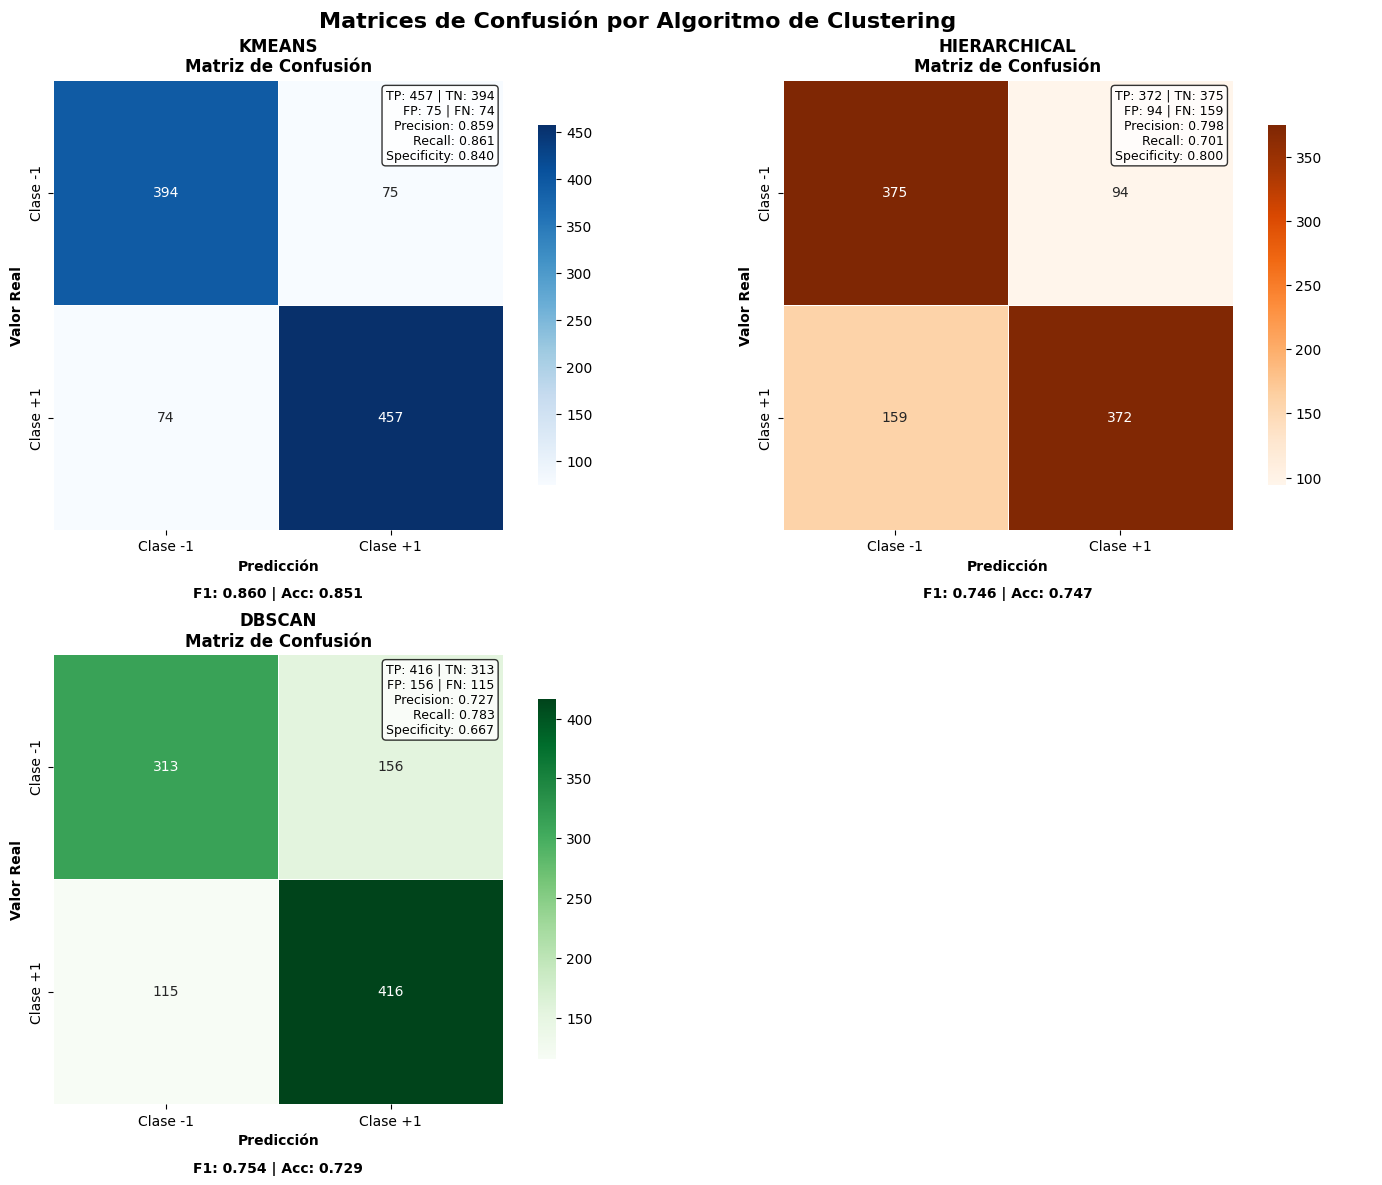

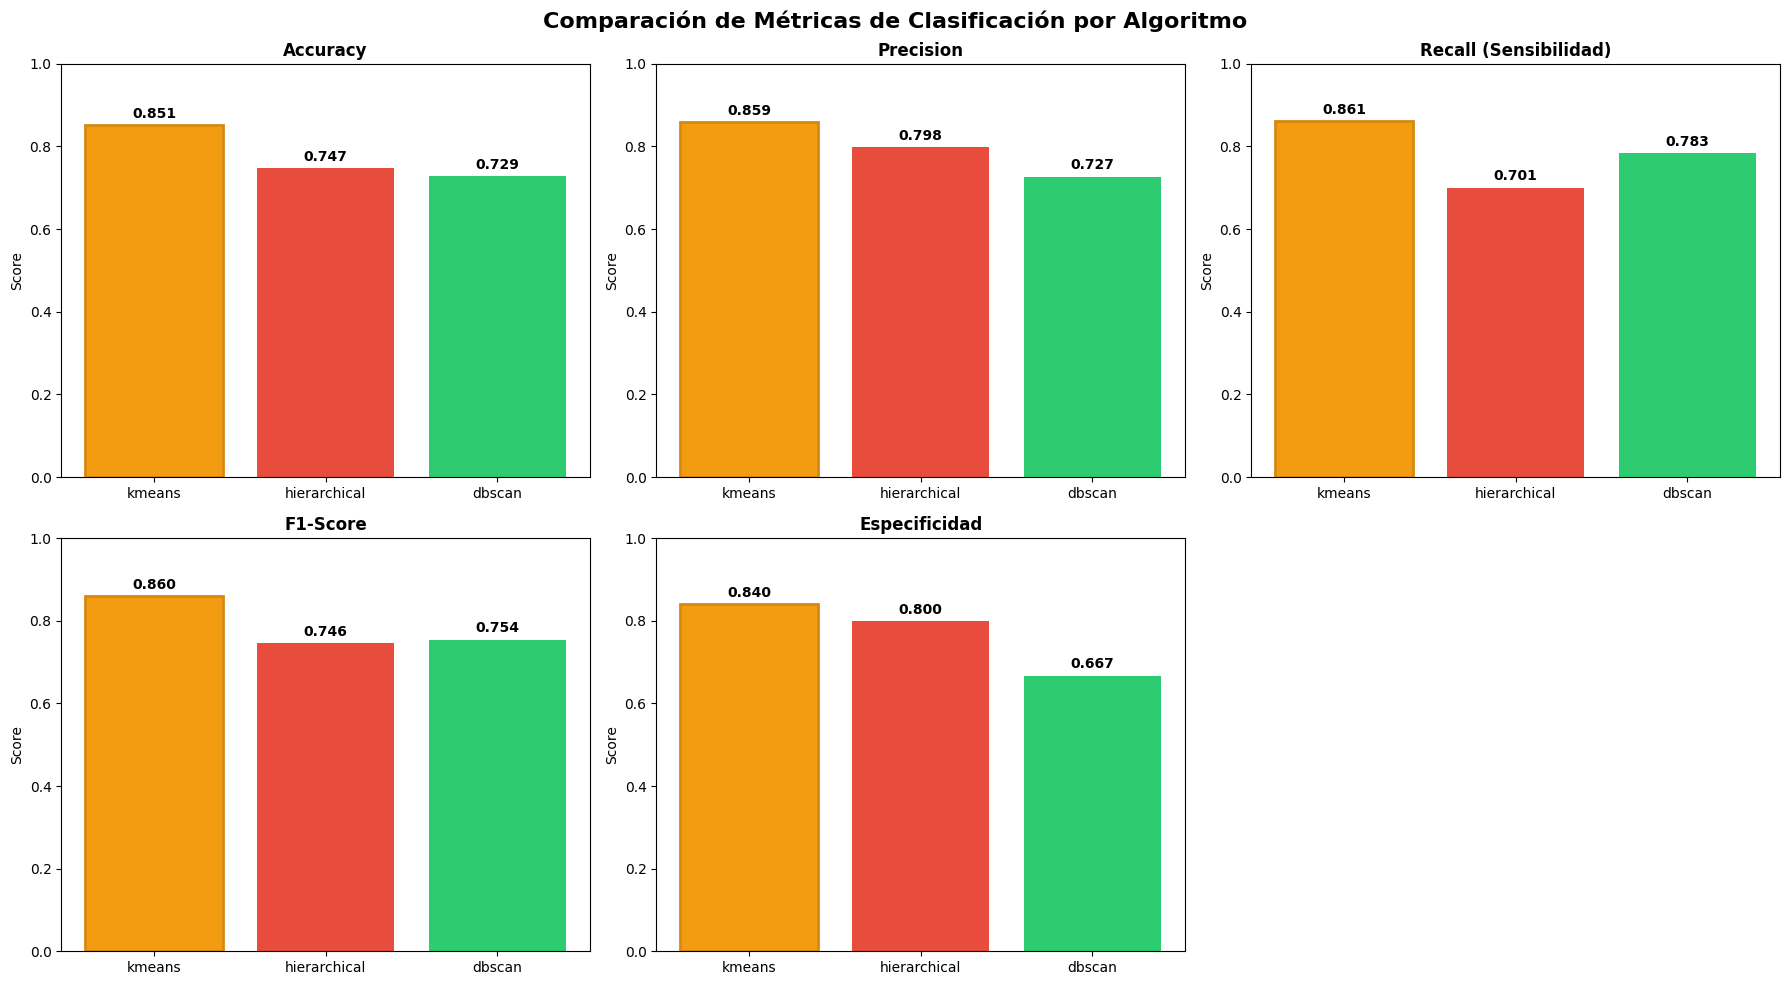

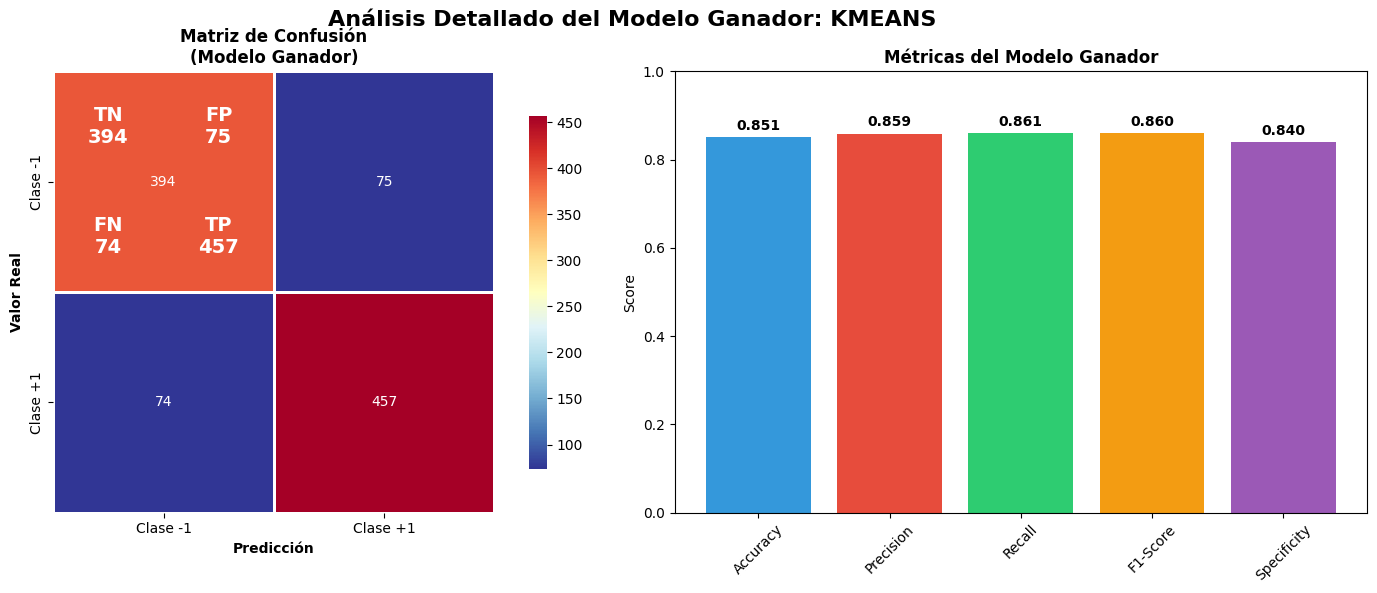

In [16]:


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Matrices de Confusión por Algoritmo de Clustering', fontsize=16, fontweight='bold')

algorithms_list = list(best_models_by_type.keys())
colors = ['Blues', 'Oranges', 'Greens']

def plot_confusion_matrix(cm, algorithm, ax, color_map):
    """
    Plot matriz de confusión con métricas detalladas
    """
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap=color_map, 
                ax=ax,
                cbar_kws={'shrink': .8},
                square=True,
                linewidths=0.5)
    
    ax.set_title(f'{algorithm.upper()}\nMatriz de Confusión', fontweight='bold', fontsize=12)
    ax.set_xlabel('Predicción', fontweight='bold')
    ax.set_ylabel('Valor Real', fontweight='bold')
    ax.set_xticklabels(['Clase -1', 'Clase +1'])
    ax.set_yticklabels(['Clase -1', 'Clase +1'])
    
    model = best_models_by_type[algorithm]
    metrics_text = f"F1: {model['f1_score']:.3f} | Acc: {model['accuracy']:.3f}"
    ax.text(0.5, -0.15, metrics_text, transform=ax.transAxes, 
            ha='center', fontsize=10, fontweight='bold')

for i, algorithm in enumerate(algorithms_list):
    row = i // 2
    col = i % 2
    
    model = best_models_by_type[algorithm]
    cm = model['confusion_matrix']
    
    plot_confusion_matrix(cm, algorithm, axes[row, col], colors[i])
    
    tn, fp, fn, tp = cm.ravel()
    
    metrics_text = (f"TP: {tp} | TN: {tn}\n"
                   f"FP: {fp} | FN: {fn}\n"
                   f"Precision: {model['precision']:.3f}\n"
                   f"Recall: {model['recall']:.3f}\n"
                   f"Specificity: {model['specificity']:.3f}")
    
    axes[row, col].text(0.98, 0.98, metrics_text, 
                       transform=axes[row, col].transAxes,
                       verticalalignment='top', horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                       fontsize=9)

if len(algorithms_list) == 3:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparación de Métricas de Clasificación por Algoritmo', fontsize=16, fontweight='bold')

algorithms = list(best_models_by_type.keys())
colors_bar = ['#3498db', '#e74c3c', '#2ecc71']

metrics_to_plot = [
    ('accuracy', 'Accuracy'),
    ('precision', 'Precision'), 
    ('recall', 'Recall (Sensibilidad)'),
    ('f1_score', 'F1-Score'),
    ('specificity', 'Especificidad'),
]

for idx, (metric_key, metric_name) in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    
    values = [best_models_by_type[alg][metric_key] for alg in algorithms]
    
    bars = axes[row, col].bar(algorithms, values, color=colors_bar)
    axes[row, col].set_title(metric_name, fontweight='bold')
    axes[row, col].set_ylabel('Score')
    axes[row, col].set_ylim(0, 1.0)
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    best_idx = values.index(max(values))
    bars[best_idx].set_color('#f39c12')
    bars[best_idx].set_edgecolor('#d68910')
    bars[best_idx].set_linewidth(2)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle(f'Análisis Detallado del Modelo Ganador: {final_best_model["algorithm"].upper()}', 
             fontsize=16, fontweight='bold')

cm_winner = final_best_model['confusion_matrix']
sns.heatmap(cm_winner, 
            annot=True, 
            fmt='d', 
            cmap='RdYlBu_r', 
            ax=ax1,
            cbar_kws={'shrink': .8},
            square=True,
            linewidths=1)

ax1.set_title('Matriz de Confusión\n(Modelo Ganador)', fontweight='bold')
ax1.set_xlabel('Predicción', fontweight='bold')
ax1.set_ylabel('Valor Real', fontweight='bold')
ax1.set_xticklabels(['Clase -1', 'Clase +1'])
ax1.set_yticklabels(['Clase -1', 'Clase +1'])

tn, fp, fn, tp = cm_winner.ravel()
ax1.text(0.25, 0.25, f'TN\n{tn}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax1.text(0.75, 0.25, f'FP\n{fp}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax1.text(0.25, 0.75, f'FN\n{fn}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax1.text(0.75, 0.75, f'TP\n{tp}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')

metrics_ganador = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
values_ganador = [final_best_model['accuracy'], final_best_model['precision'], 
                 final_best_model['recall'], final_best_model['f1_score'], 
                 final_best_model['specificity']]

bars_ganador = ax2.bar(metrics_ganador, values_ganador, 
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
ax2.set_title('Métricas del Modelo Ganador', fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_ylim(0, 1.0)
ax2.tick_params(axis='x', rotation=45)

for bar, value in zip(bars_ganador, values_ganador):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## Parte 7.1: Visualizaciones de Predicciones Finales

**Objetivo**: Visualizar las predicciones generadas y su distribución en el espacio de características.

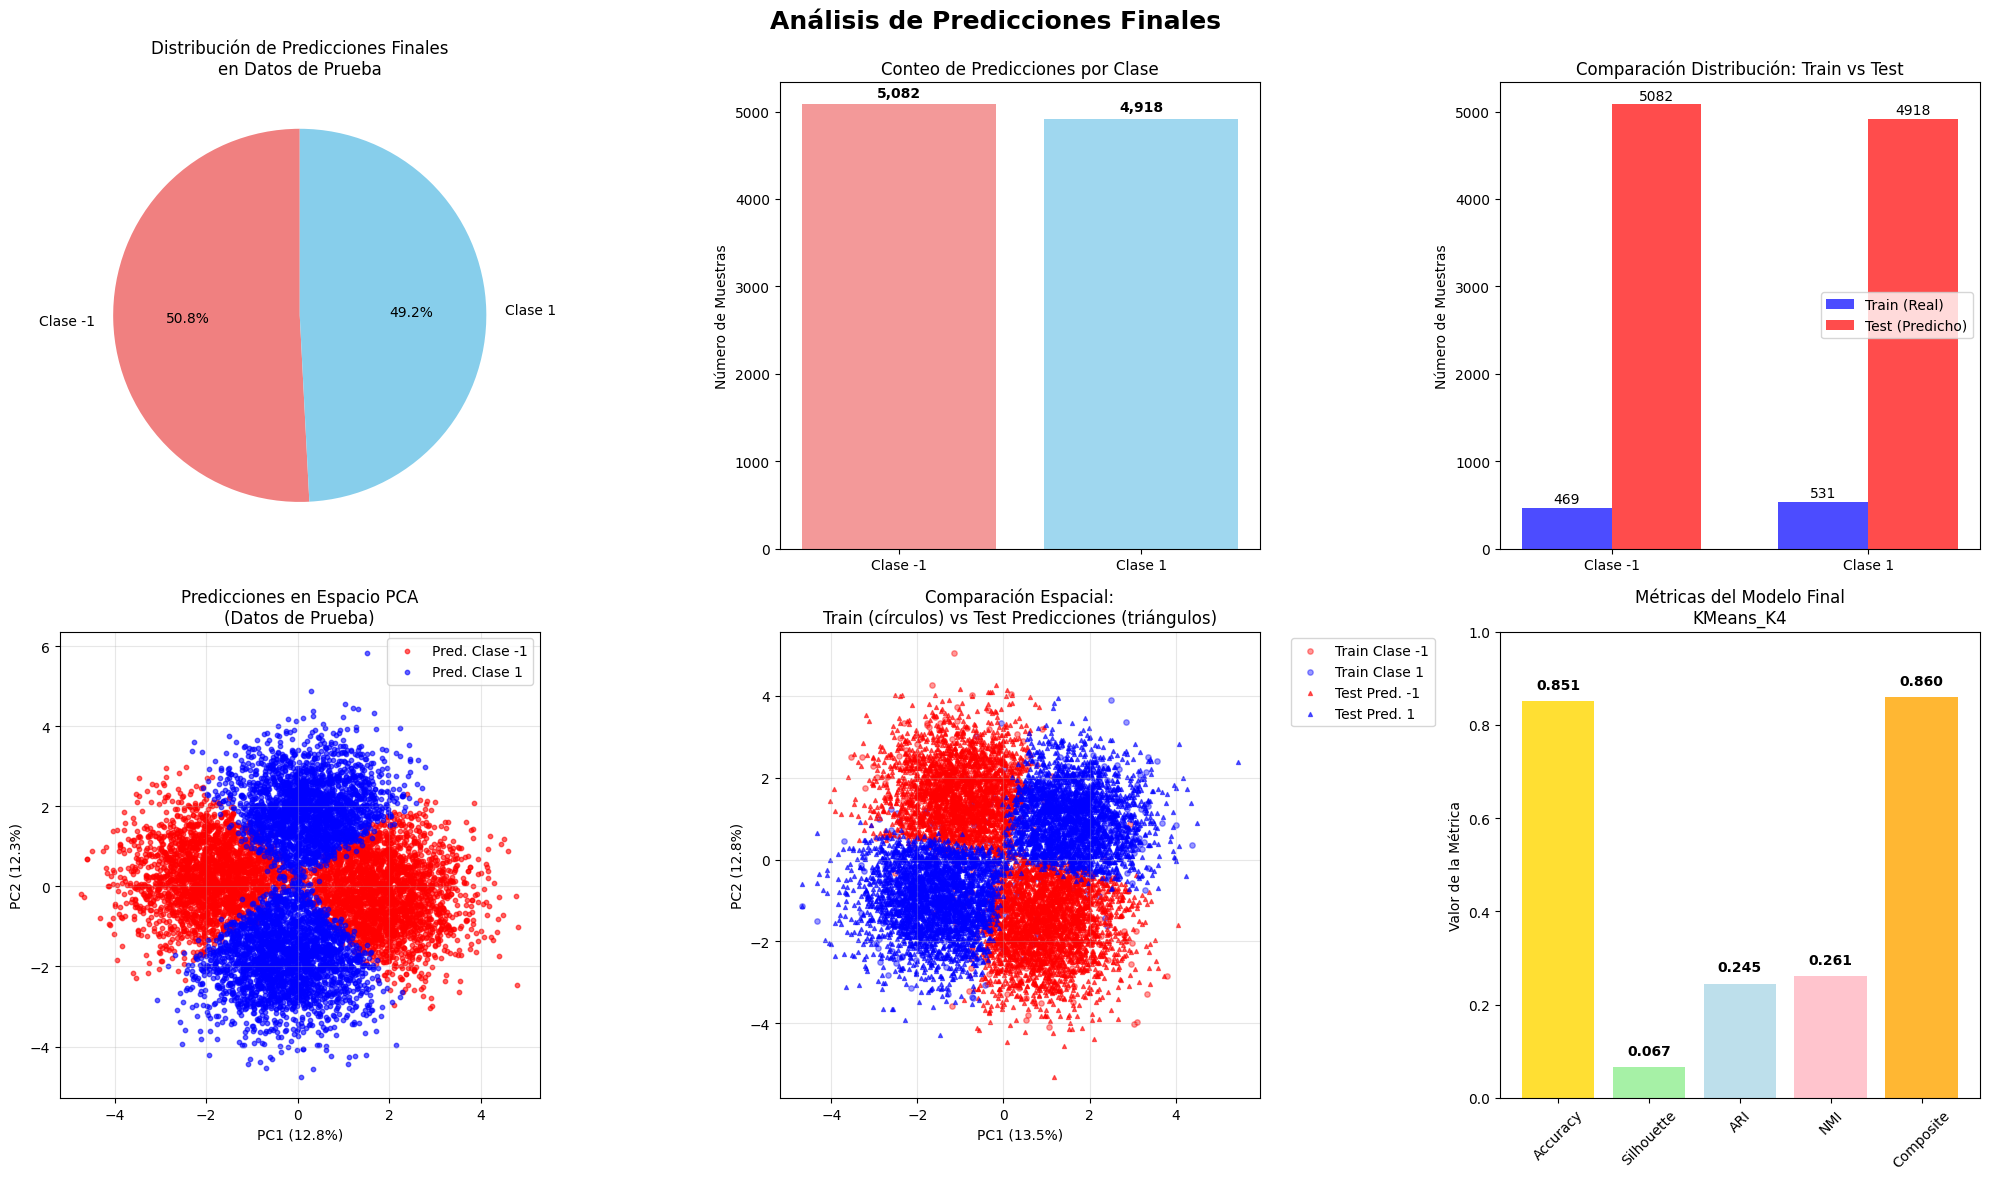

In [17]:


unique_final, counts_final = np.unique(test_predictions_final, return_counts=True)

pca_test = PCA(n_components=2)
X_test_pca = pca_test.fit_transform(X_test_scaled)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis de Predicciones Finales', fontsize=18, fontweight='bold')

axes[0,0].pie(counts_final, labels=[f'Clase {int(c)}' for c in unique_final], 
              autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
axes[0,0].set_title('Distribución de Predicciones Finales\nen Datos de Prueba')

axes[0,1].bar([f'Clase {int(c)}' for c in unique_final], counts_final, 
              color=['lightcoral', 'skyblue'], alpha=0.8)
axes[0,1].set_title('Conteo de Predicciones por Clase')
axes[0,1].set_ylabel('Número de Muestras')
for i, v in enumerate(counts_final):
    axes[0,1].text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')

train_counts = [np.sum(y_train == c) for c in unique_classes]
test_counts = [np.sum(test_predictions_final == c) for c in unique_classes]

x = np.arange(len(unique_classes))
width = 0.35

axes[0,2].bar(x - width/2, train_counts, width, label='Train (Real)', color='blue', alpha=0.7)
axes[0,2].bar(x + width/2, test_counts, width, label='Test (Predicho)', color='red', alpha=0.7)
axes[0,2].set_title('Comparación Distribución: Train vs Test')
axes[0,2].set_ylabel('Número de Muestras')
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels([f'Clase {int(c)}' for c in unique_classes])
axes[0,2].legend()

for i, (train_v, test_v) in enumerate(zip(train_counts, test_counts)):
    axes[0,2].text(i - width/2, train_v + 20, f'{train_v}', ha='center', va='bottom', fontsize=10)
    axes[0,2].text(i + width/2, test_v + 20, f'{test_v}', ha='center', va='bottom', fontsize=10)

colors_pred = ['red', 'blue']
for i, clase in enumerate(unique_final):
    mask = test_predictions_final == clase
    axes[1,0].scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], 
                     c=colors_pred[i], label=f'Pred. Clase {int(clase)}', 
                     alpha=0.6, s=10)
axes[1,0].set_title('Predicciones en Espacio PCA\n(Datos de Prueba)')
axes[1,0].set_xlabel(f'PC1 ({pca_test.explained_variance_ratio_[0]:.1%})')
axes[1,0].set_ylabel(f'PC2 ({pca_test.explained_variance_ratio_[1]:.1%})')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

pca_combined = PCA(n_components=2)
X_train_pca_combined = pca_combined.fit_transform(X_train_scaled)
X_test_pca_combined = pca_combined.transform(X_test_scaled)

for i, clase in enumerate(unique_classes):
    mask = y_train == clase
    axes[1,1].scatter(X_train_pca_combined[mask, 0], X_train_pca_combined[mask, 1], 
                     c=colors_pred[i], label=f'Train Clase {int(clase)}', 
                     alpha=0.4, s=15, marker='o')

for i, clase in enumerate(unique_final):
    mask = test_predictions_final == clase
    axes[1,1].scatter(X_test_pca_combined[mask, 0], X_test_pca_combined[mask, 1], 
                     c=colors_pred[i], label=f'Test Pred. {int(clase)}', 
                     alpha=0.6, s=8, marker='^')

axes[1,1].set_title('Comparación Espacial:\nTrain (círculos) vs Test Predicciones (triángulos)')
axes[1,1].set_xlabel(f'PC1 ({pca_combined.explained_variance_ratio_[0]:.1%})')
axes[1,1].set_ylabel(f'PC2 ({pca_combined.explained_variance_ratio_[1]:.1%})')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(True, alpha=0.3)

metrics_names = ['Accuracy', 'Silhouette', 'ARI', 'NMI', 'Composite']
metrics_values = [
    final_best_model['accuracy'],
    final_best_model['silhouette'],
    final_best_model['ari'],
    final_best_model['nmi'],
    final_best_model['f1_score']
]

bars = axes[1,2].bar(metrics_names, metrics_values, 
                    color=['gold', 'lightgreen', 'lightblue', 'lightpink', 'orange'], 
                    alpha=0.8)
axes[1,2].set_title(f'Métricas del Modelo Final\n{final_best_model["name"]}')
axes[1,2].set_ylabel('Valor de la Métrica')
axes[1,2].set_ylim(0, 1)
axes[1,2].tick_params(axis='x', rotation=45)

for bar, value in zip(bars, metrics_values):
    axes[1,2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02, 
                  f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
